In [1]:
import numpy as np
import pandas as pd
import math
import itertools
from sklearn.metrics import DistanceMetric
import networkx as nx
from numpy import inf
from scipy import linalg
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score



In [2]:
  # Uploading the files
df = pd.read_csv("HeartFailure.csv")
df_cluster = df.iloc[:,1:11]
df_cluster.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex
0,75.0,0,582,0,20,1,265000.00,1.9,130,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0


In [3]:
def datapreprocessing(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_normalized = normalize(df_scaled)
    df_normalized = pd.DataFrame(df_normalized)
    pca = PCA(n_components = 2)
    df_principal = pca.fit_transform(df_normalized)
    df_principal = pd.DataFrame(df_principal)
    df_principal.columns = ['P1', 'P2']
    return df_principal

In [4]:
df_pca_cluster= datapreprocessing(df_cluster)

In [5]:
# coverting the input csv file into a graph
'''  '''
def getGraph(df,measure) :
    
    dist = DistanceMetric.get_metric(measure)
    matrix_dist = dist.pairwise(df.to_numpy())
    Graph=nx.from_numpy_matrix(matrix_dist)
    draw_graph(Graph)
    
    return matrix_dist, Graph
    

In [6]:
#Function to draw graph
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

array([[     0.        ,   7461.94801114, 103000.92328887, ...,
        477002.29250205, 125013.41482517, 130000.5780106 ],
       [  7461.94801114,      0.        , 101651.22696515, ...,
        478677.1225331 , 123478.27495382, 131864.93303654],
       [103000.92328887, 101651.22696515,      0.        , ...,
        580003.1598873 ,  22116.51270002, 233000.00729418],
       ...,
       [477002.29250205, 478677.1225331 , 580003.1598873 , ...,
             0.        , 602000.10390311, 347005.00681206],
       [125013.41482517, 123478.27495382,  22116.51270002, ...,
        602000.10390311,      0.        , 255009.63742384],
       [130000.5780106 , 131864.93303654, 233000.00729418, ...,
        347005.00681206, 255009.63742384,      0.        ]])

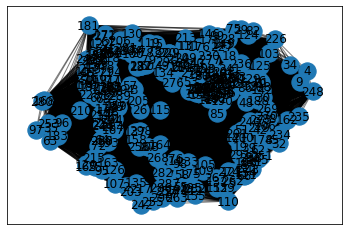

In [7]:
matrix_dist, Graph = getGraph(df_cluster,"euclidean")
matrix_dist

In [8]:
#equation fro adjacency matrix
def equation(df, sigma, distance):
    dim = df.shape[0]
    A = np.zeros([dim, dim])
    dist = iter(pdist(df, metric=distance))
#     matrix_dist = dist.pairwise(df.to_numpy())
    for i in range(dim):
        for j in range(i+1, dim):  
            d = np.exp(-next(dist) ** 2) / (2. * sigma ** 2)
            A[i,j] = d
            A[j,i] = d
    return A


In [9]:
adjacency_matrix = equation(df_pca_cluster, 0.3, 'euclidean')
# adacency_matrix= getAjacency(df_cluster)
adjacency_matrix


array([[0.        , 4.73765499, 4.42668018, ..., 2.22262191, 4.3955364 ,
        4.6994128 ],
       [4.73765499, 0.        , 4.55821815, ..., 3.54834637, 5.0767855 ,
        5.42109133],
       [4.42668018, 4.55821815, 0.        , ..., 1.63249413, 5.3711021 ,
        5.09157925],
       ...,
       [2.22262191, 3.54834637, 1.63249413, ..., 0.        , 2.30271701,
        2.87608415],
       [4.3955364 , 5.0767855 , 5.3711021 , ..., 2.30271701, 0.        ,
        5.44086469],
       [4.6994128 , 5.42109133, 5.09157925, ..., 2.87608415, 5.44086469,
        0.        ]])

In [10]:
def getLaplacian(Graph,matrix_dist):
    D = Graph.degree()
    degrees = [val for (node, val) in Graph.degree()]
    D = np.zeros((len(degrees), len(degrees)))
    np.fill_diagonal(D, degrees)
    print('degree matrix:')
    print(D)
    L = D - matrix_dist
    
#Normalized laplacian matrix
    D_half = linalg.fractional_matrix_power(D, -0.5)
    LN = np.matmul(np.matmul(D_half, L), D_half)
    
 
    print('laplacian matrix:')
    print(LN)
    return D,L,LN


In [11]:
def getEigen(LN):
    e, v = np.linalg.eig(LN)
        # eigenvalues
    print('eigenvalues:')
    print(e)
        # eigenvectors
    print('eigenvectors:')
    print(v)
    return e,v
    

In [13]:
D,L,LN = getLaplacian(Graph,adjacency_matrix)

degree matrix:
[[298.   0.   0. ...   0.   0.   0.]
 [  0. 298.   0. ...   0.   0.   0.]
 [  0.   0. 298. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 298.   0.   0.]
 [  0.   0.   0. ...   0. 298.   0.]
 [  0.   0.   0. ...   0.   0. 298.]]
laplacian matrix:
[[ 1.         -0.01589817 -0.01485463 ... -0.00745846 -0.01475012
  -0.01576984]
 [-0.01589817  1.         -0.01529603 ... -0.0119072  -0.01703619
  -0.01819158]
 [-0.01485463 -0.01529603  1.         ... -0.00547817 -0.01802383
  -0.01708584]
 ...
 [-0.00745846 -0.0119072  -0.00547817 ...  1.         -0.00772724
  -0.00965129]
 [-0.01475012 -0.01703619 -0.01802383 ... -0.00772724  1.
  -0.01825794]
 [-0.01576984 -0.01819158 -0.01708584 ... -0.00965129 -0.01825794
   1.        ]]


In [17]:
LN

array([[ 1.        , -0.01589817, -0.01485463, ..., -0.00745846,
        -0.01475012, -0.01576984],
       [-0.01589817,  1.        , -0.01529603, ..., -0.0119072 ,
        -0.01703619, -0.01819158],
       [-0.01485463, -0.01529603,  1.        , ..., -0.00547817,
        -0.01802383, -0.01708584],
       ...,
       [-0.00745846, -0.0119072 , -0.00547817, ...,  1.        ,
        -0.00772724, -0.00965129],
       [-0.01475012, -0.01703619, -0.01802383, ..., -0.00772724,
         1.        , -0.01825794],
       [-0.01576984, -0.01819158, -0.01708584, ..., -0.00965129,
        -0.01825794,  1.        ]])

In [14]:
e,v = getEigen(LN)

eigenvalues:
[-2.48770062+0.00000000e+00j  0.16279317+0.00000000e+00j
  0.2971171 +0.00000000e+00j  0.8538575 +0.00000000e+00j
  0.88358915+0.00000000e+00j  0.90940625+0.00000000e+00j
  0.98807776+0.00000000e+00j  1.00137306+0.00000000e+00j
  1.00341054+0.00000000e+00j  1.00972088+0.00000000e+00j
  1.01519756+0.00000000e+00j  1.0164639 +0.00000000e+00j
  1.01734899+0.00000000e+00j  1.01755368+0.00000000e+00j
  1.01808728+0.00000000e+00j  1.01837285+0.00000000e+00j
  1.0184202 +0.00000000e+00j  1.01853666+0.00000000e+00j
  1.01854839+0.00000000e+00j  1.01857652+0.00000000e+00j
  1.01861329+0.00000000e+00j  1.01862283+0.00000000e+00j
  1.01862656+0.00000000e+00j  1.01863427+0.00000000e+00j
  1.01863738+0.00000000e+00j  1.01863806+0.00000000e+00j
  1.01863994+0.00000000e+00j  1.01864097+0.00000000e+00j
  1.01864144+0.00000000e+00j  1.01864192+0.00000000e+00j
  1.01864226+0.00000000e+00j  1.01864243+0.00000000e+00j
  1.01864259+0.00000000e+00j  1.01864261+0.00000000e+00j
  1.01864269+0.000

C:\Users\sitas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


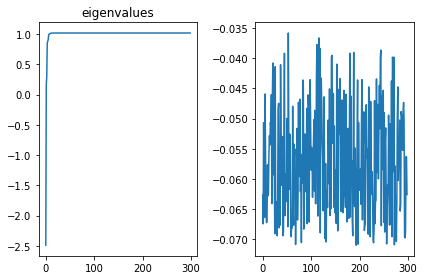

In [15]:
fig = plt.figure()
ax1 = plt.subplot(121)
plt.plot(e)
ax1.title.set_text('eigenvalues')
i = np.where(e < 10e-6)[0]
ax2 = plt.subplot(122)
plt.plot(v[:, i[0]])
fig.tight_layout()
plt.show()

In [ ]:
#find optimal number of clusters

def silhouette(df):
    range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14]
    silhouette_avg = []

    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        cluster_labels = kmeans.labels_  
        silhouette_avg.append(silhouette_score(df, cluster_labels))
        
    plt.plot(range_n_clusters,silhouette_avg,'-bx')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()
    


In [ ]:
silhouette(df_cluster)

In [ ]:
silhouette(df_pca_cluster)

In [ ]:
def elbowmethod(df):
    Sum_of_squared_distances = []
    K = range(1,10)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df)
        Sum_of_squared_distances.append(kmeans.inertia_)
    plt.plot(K,Sum_of_squared_distances,'-bx')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances/') 
    plt.title('Elbow Method For Optimal k')
    plt.show()
    


In [ ]:
elbowmethod(df_cluster)

In [ ]:
elbowmethod(df_pca_cluster)

In [ ]:
U = np.array(v[:, i[0]])
km = KMeans(init='k-means++', n_clusters=3)
df['clusters'] = km.fit_predict(U)
df